In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *
from utils.model import *

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim

## Step-by-Step Data Preprocessing Demo

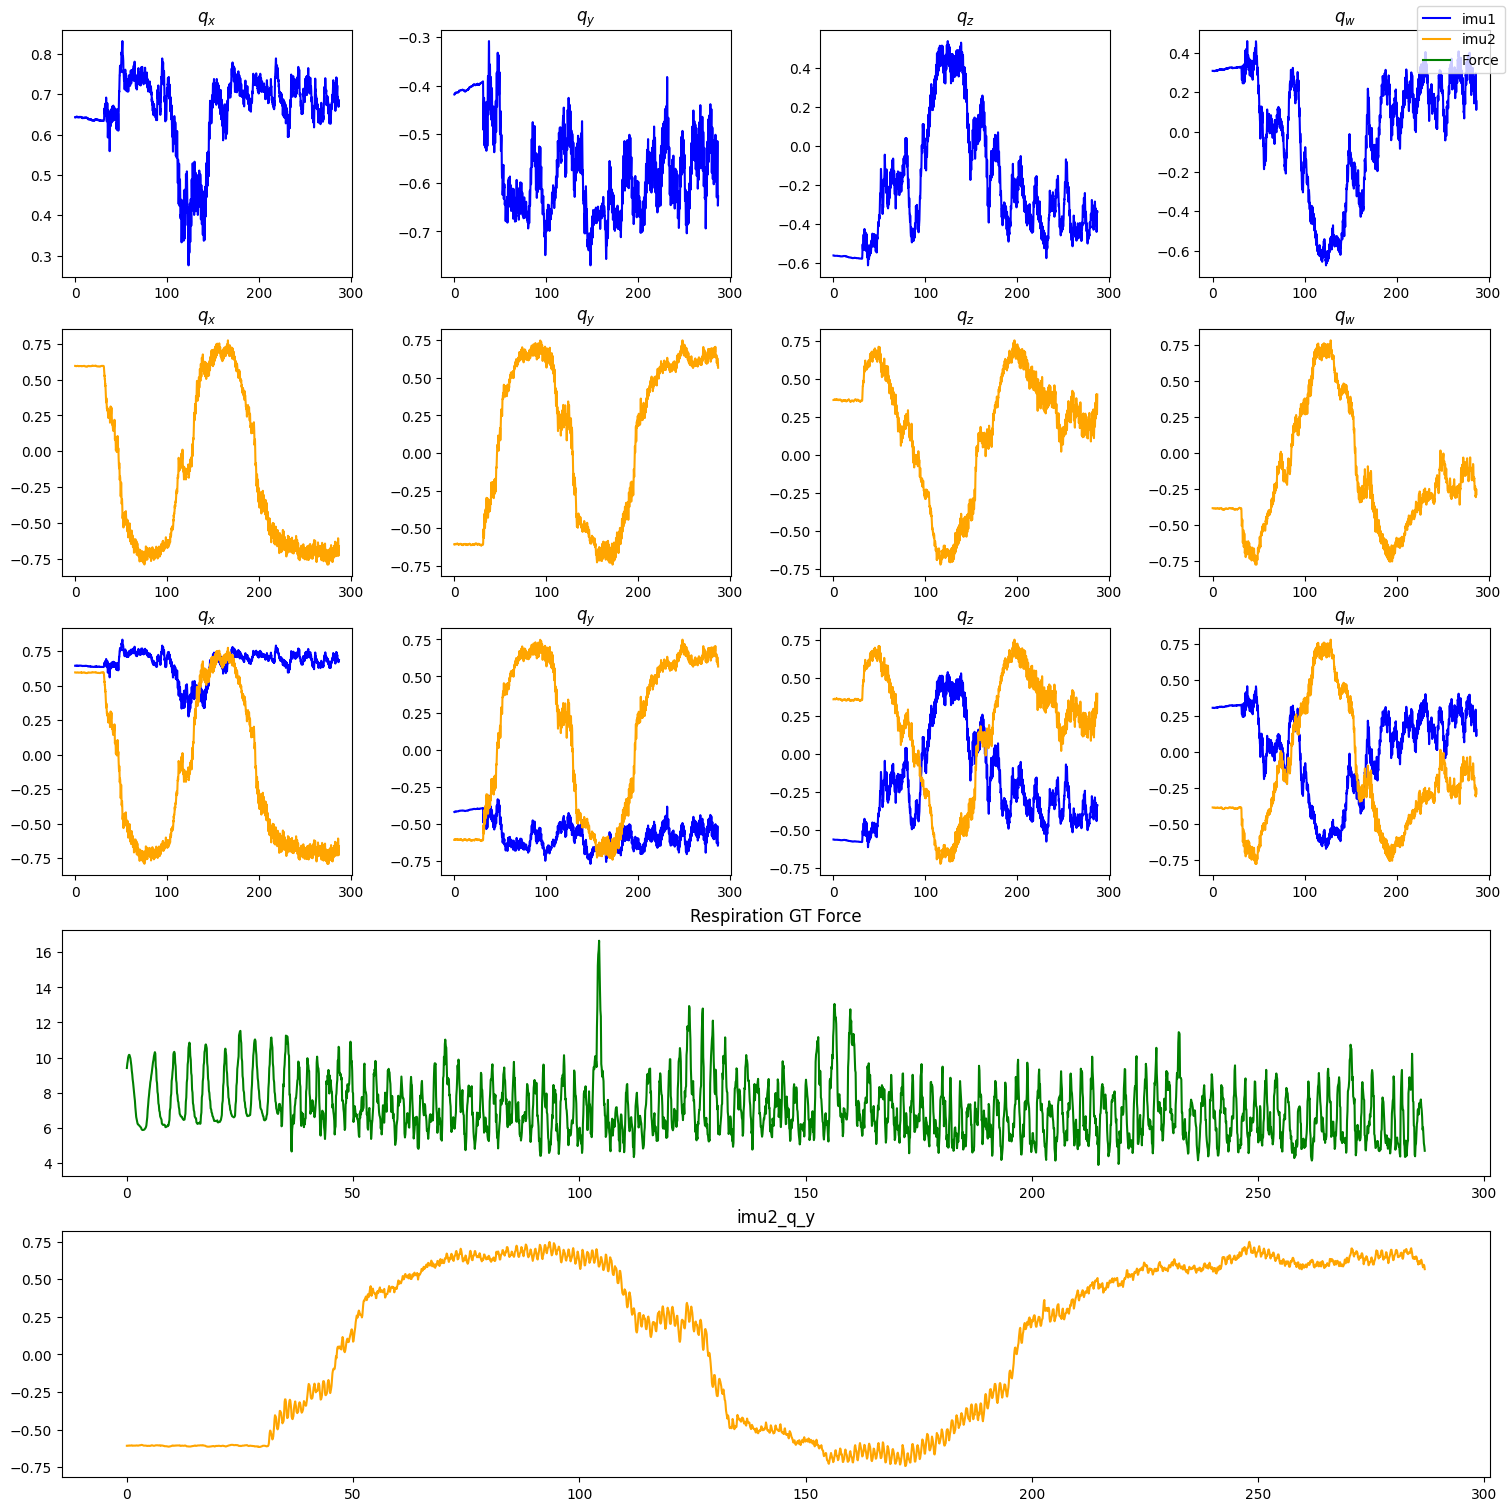

In [2]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

# file_path = "./data/3_27/walk_stand_4.csv" 
file_path = "./data/3_28/walk_stand_0328_0236.csv" 

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

best_score/total: 300/300


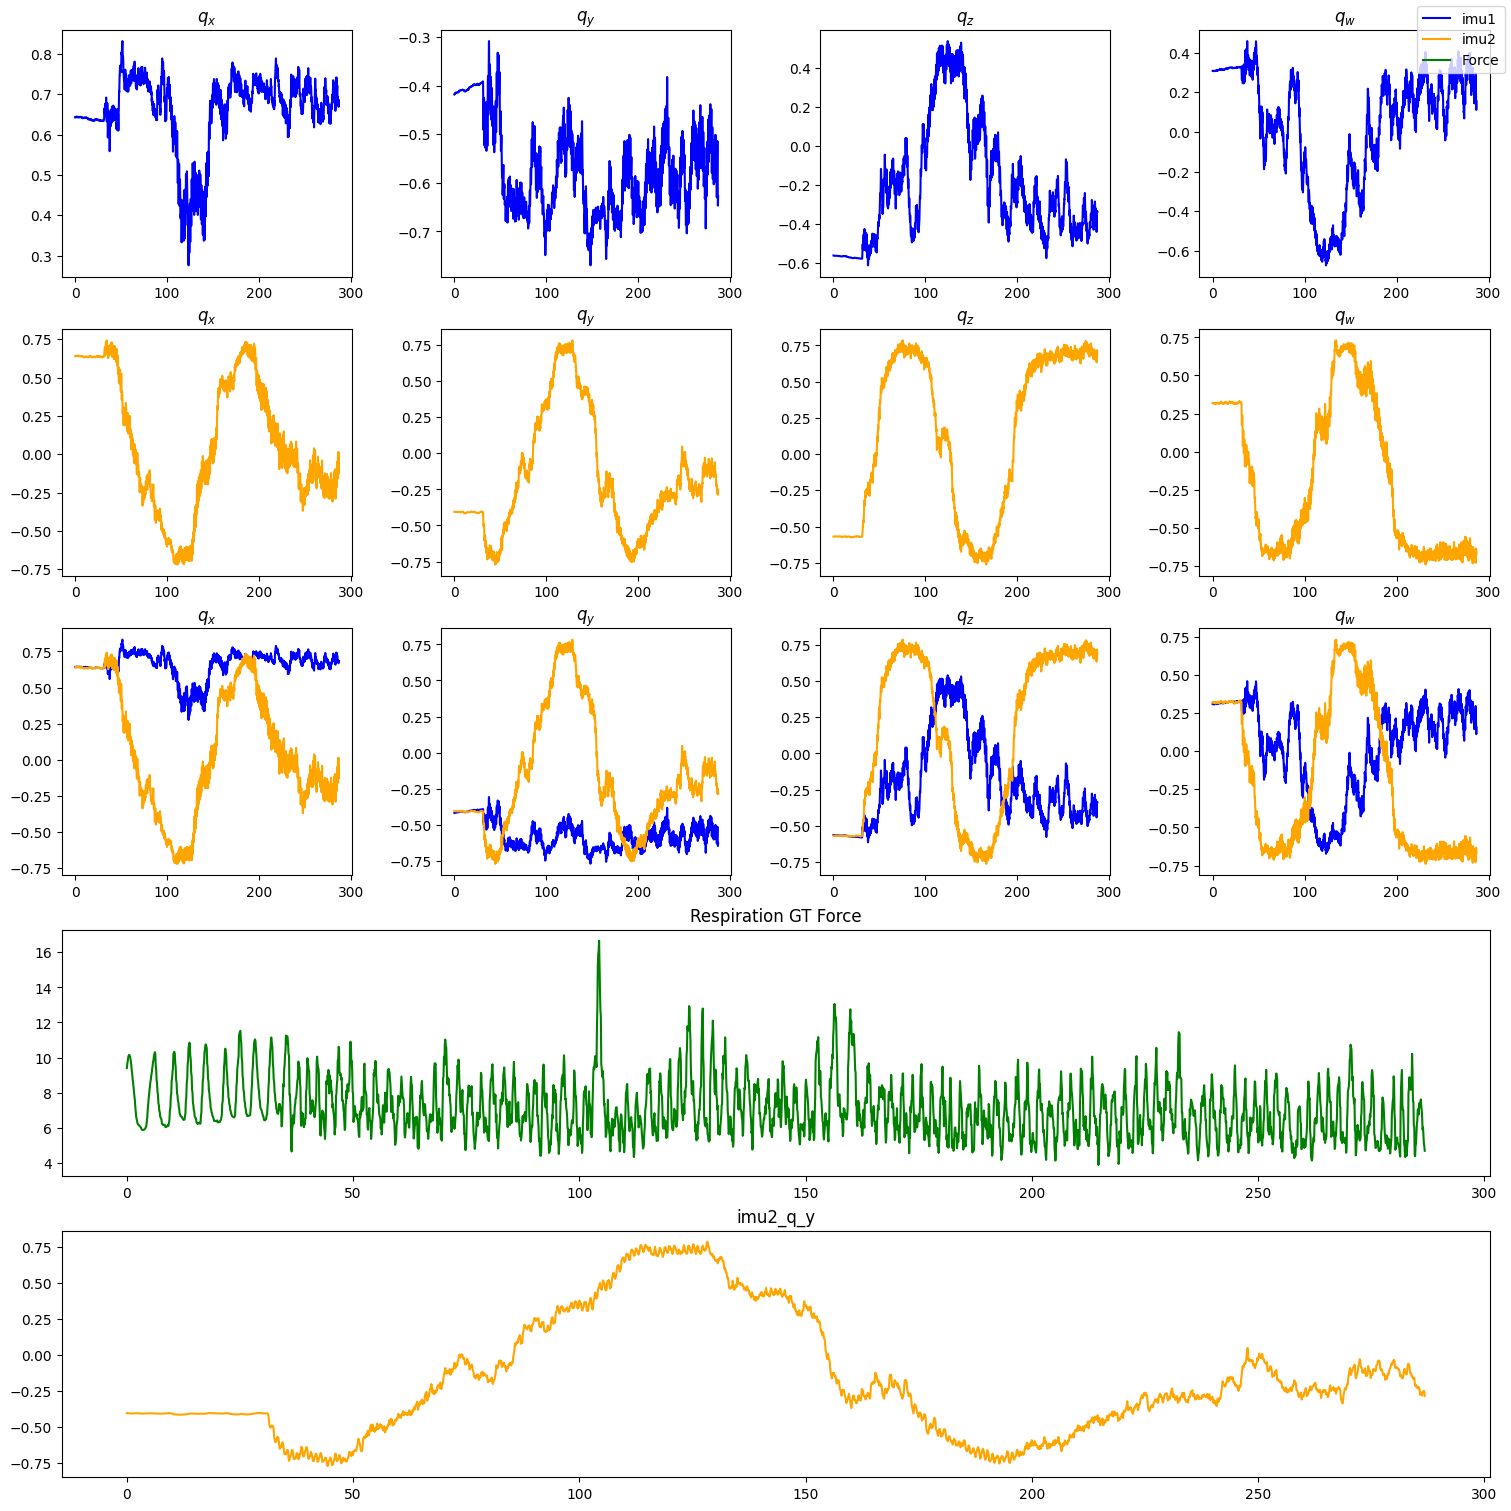

In [3]:
# Align IMUs (IMU2 -> IMU1)
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

draw_imu_curve(data_aligned, overlap=True, show_gt=True)

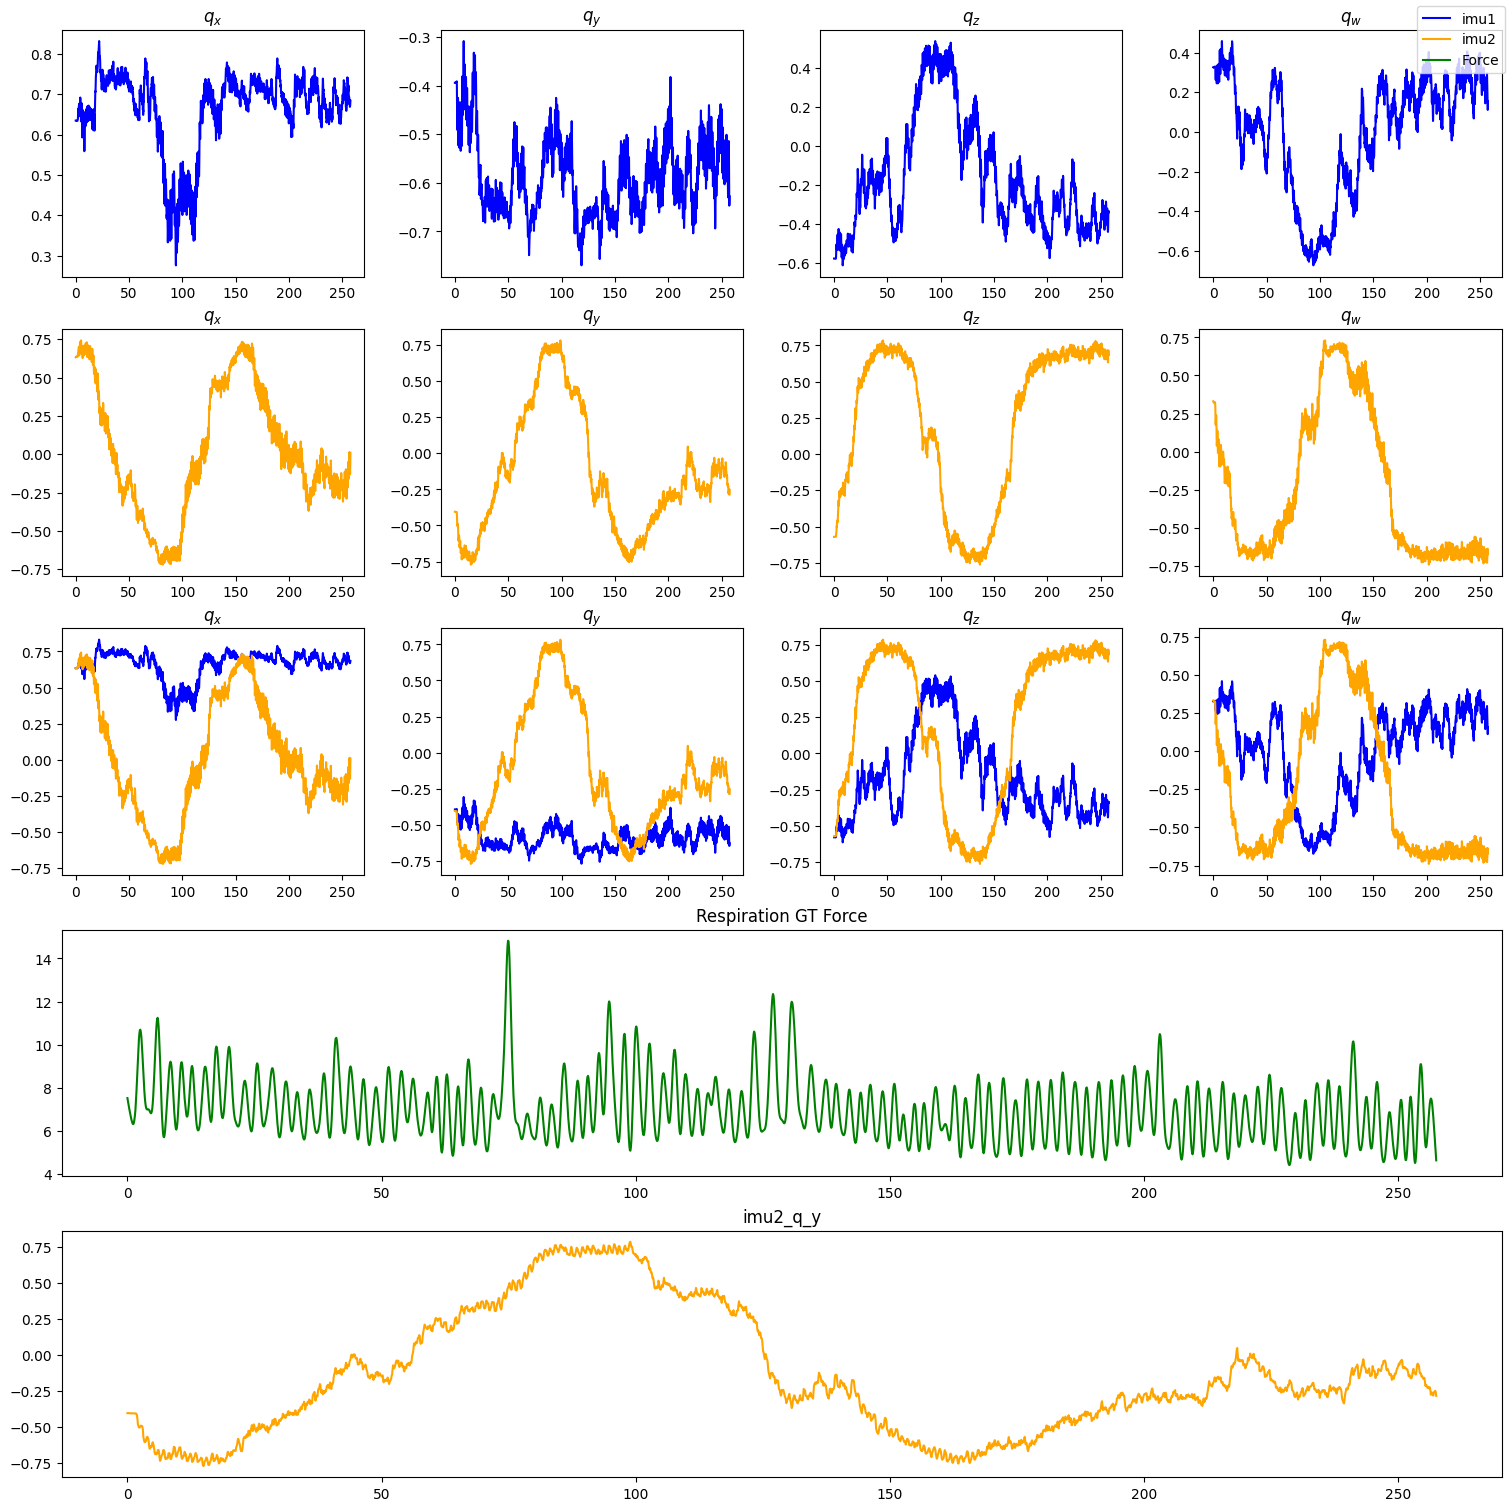

In [4]:
# Handle gt force
data_sp = data_aligned # data used in compute spectrogram shape
data_sp = data_sp[still_pt+0:]
cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion

data_sp.loc[:, "Force"] = butter_filter(data_sp["Force"], cutoff=0.66)
draw_imu_curve(data_sp, overlap=True, show_gt=True)

## Compute Model Parameters (Spectrogram Shape)

In [5]:
file_path = "./data/hamham/train/walk_stand_2.csv" 

spectrograms_file, gts_file, times_file = prepare_file(file_path)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

num_channels = spectrograms_file.shape[1]
num_freq_bins = spectrograms_file.shape[2]  # From computed spectrogram
num_time_steps = spectrograms_file.shape[3]  # From computed spectrogram

best_score/total: 300/300
----------------------------
sepctrograms:(38, 8, 65, 1)
gt:(38, 1)
times:(38,)


In [6]:
torch.cuda.is_available()

True

## Prepare Dataset

In [7]:
# prepare train, testing dataset
path_train = './data/hamham/train/'
path_test = './data/hamham/test/'
spectrograms_train, gts_train = prepare_data(path_train)
spectrograms_test, gts_test = prepare_data(path_test)

./data/hamham/train/mix_1.csv
best_score/total: 145/300
./data/hamham/train/mix_2.csv
best_score/total: 215/300
./data/hamham/train/run_stand_1.csv
best_score/total: 51/300
./data/hamham/train/run_stand_2.csv
best_score/total: 140/300
./data/hamham/train/run_stand_4.csv
best_score/total: 59/300
./data/hamham/train/sit_1.csv
best_score/total: 300/300
./data/hamham/train/sit_2.csv
best_score/total: 231/300
./data/hamham/train/sit_4.csv
best_score/total: 300/300
./data/hamham/train/stand_1.csv
best_score/total: 300/300
./data/hamham/train/stand_2.csv
best_score/total: 300/300
./data/hamham/train/stand_4.csv
best_score/total: 300/300
./data/hamham/train/walk_stand_1.csv
best_score/total: 50/300
./data/hamham/train/walk_stand_2.csv
best_score/total: 300/300
./data/hamham/train/walk_stand_4.csv
best_score/total: 187/300
----------------------------
sepctrograms:(532, 8, 65, 1)
gt:(532, 1)
./data/hamham/test/mix_3.csv
best_score/total: 42/300
./data/hamham/test/run_stand_3.csv
best_score/tota

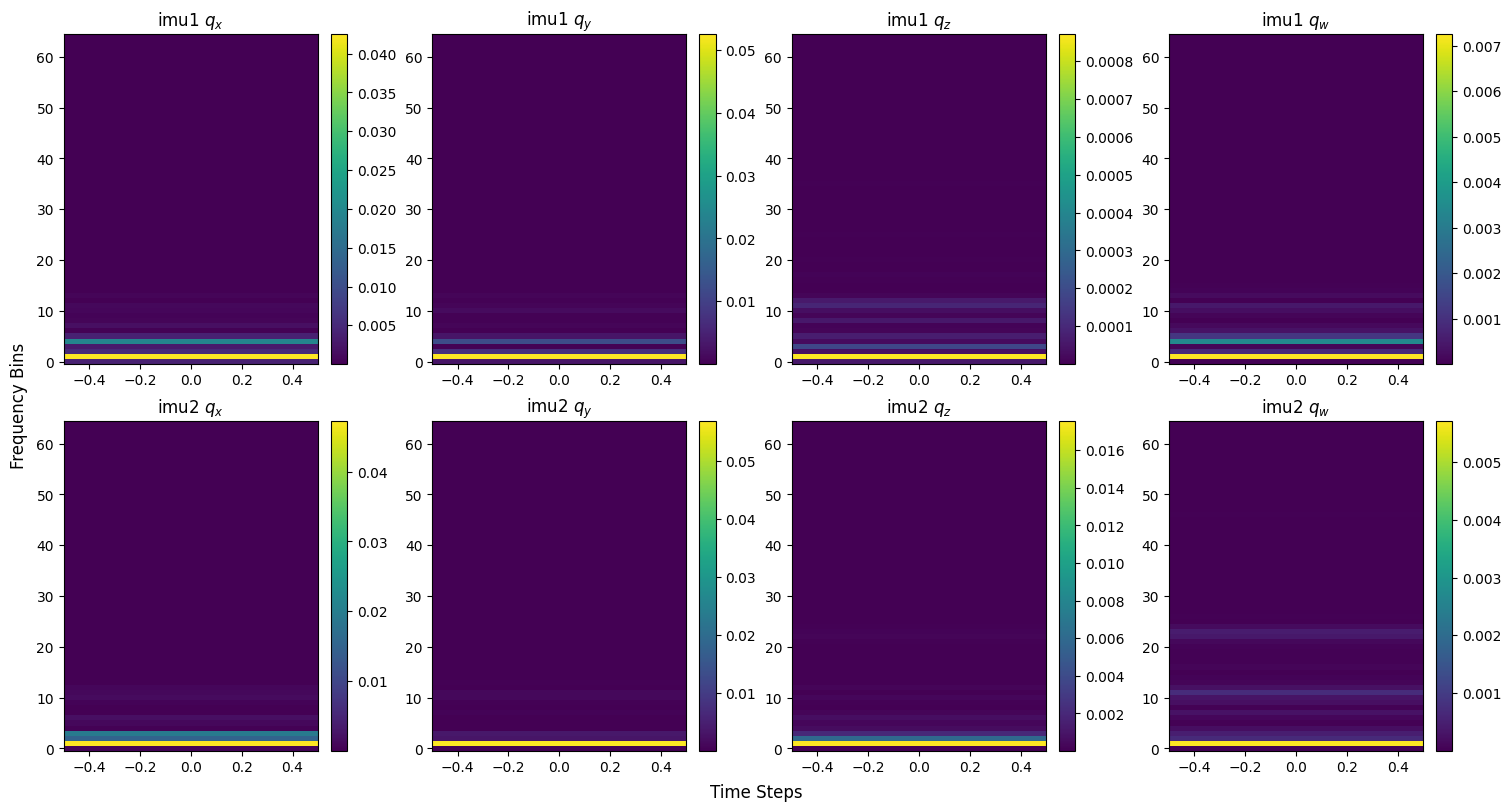

In [8]:
# show one spectrogram
plot_spectrogram(spectrograms_train[0])

## Train Model: Spectrogram with MLP

Epoch 1/100, Train MSE: 0.0040, L1: 2.8331, Test MSE: 0.0030, L1: 2.7808
Epoch 2/100, Train MSE: 0.0036, L1: 2.6427, Test MSE: 0.0050, L1: 3.1522
Epoch 3/100, Train MSE: 0.0034, L1: 2.4890, Test MSE: 0.0042, L1: 2.8607
Epoch 4/100, Train MSE: 0.0033, L1: 2.5341, Test MSE: 0.0036, L1: 2.6807
Epoch 5/100, Train MSE: 0.0034, L1: 2.5454, Test MSE: 0.0056, L1: 3.3944
Epoch 6/100, Train MSE: 0.0031, L1: 2.3964, Test MSE: 0.0034, L1: 2.5968
Epoch 7/100, Train MSE: 0.0032, L1: 2.4216, Test MSE: 0.0032, L1: 2.6159
Epoch 8/100, Train MSE: 0.0030, L1: 2.3510, Test MSE: 0.0047, L1: 3.0515
Epoch 9/100, Train MSE: 0.0031, L1: 2.3487, Test MSE: 0.0038, L1: 2.7160
Epoch 10/100, Train MSE: 0.0030, L1: 2.3907, Test MSE: 0.0034, L1: 2.6128
Epoch 11/100, Train MSE: 0.0030, L1: 2.3671, Test MSE: 0.0031, L1: 2.5556
Epoch 12/100, Train MSE: 0.0029, L1: 2.2850, Test MSE: 0.0033, L1: 2.5768
Epoch 13/100, Train MSE: 0.0030, L1: 2.3759, Test MSE: 0.0034, L1: 2.6550
Epoch 14/100, Train MSE: 0.0029, L1: 2.2686, Te

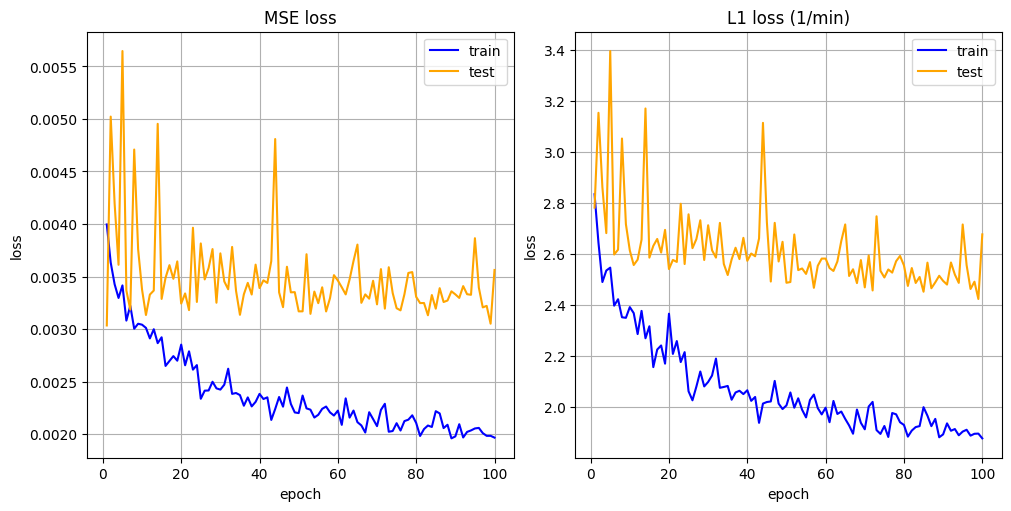

In [9]:
# Load dataset
# spectrograms_train = np.log(spectrograms_train) # log info
dataset_train = IMUSpectrogramDataset(spectrograms_train, gts_train)
dataset_test = IMUSpectrogramDataset(spectrograms_test, gts_test)
train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True) # batch_size=16
test_loader = DataLoader(dataset_test, batch_size=4, shuffle=True)

# model = MLP(num_freq_bins, num_time_steps, num_channels=num_channels)
model = CNN_1D(num_freq_bins, num_time_steps, num_channels=num_channels)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
now = datetime.now()
model_name = now.strftime("%m%d_%H.%M.%S") # MM_DD_HH:mm:ss
train_model(model, train_loader, test_loader, num_epochs=100, name=model_name, device=device, visualize=True)

## Testing Model

In [10]:
# Load model
model_name = '0327_CNN'
model = CNN_1D(num_freq_bins, num_time_steps, num_channels=num_channels)
model.load_state_dict(torch.load(f'./models/{str(model_name)}.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate model in whole testing set
mse, mae = evaluate_model(model, test_loader, device=device)

model Evaluation Results - MSE Loss: 0.0029, L1 Loss: 2.3444 1/min


In [11]:
# Test one file
action_name = "run_stand_5"
# sit_3, stand_3, walk_stand_3, run_stand_3
# sit_5, stand_5, walk_stand_5, run_stand_5, mix_3
# path_file = f'./data/hamham/test/{action_name}.csv'
path_file = f'./data/3_27/{action_name}.csv'

spectrograms_file, gts_file, times_file = prepare_file(path_file)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

best_score/total: 134/300
----------------------------
sepctrograms:(41, 8, 65, 1)
gt:(41, 1)
times:(41,)


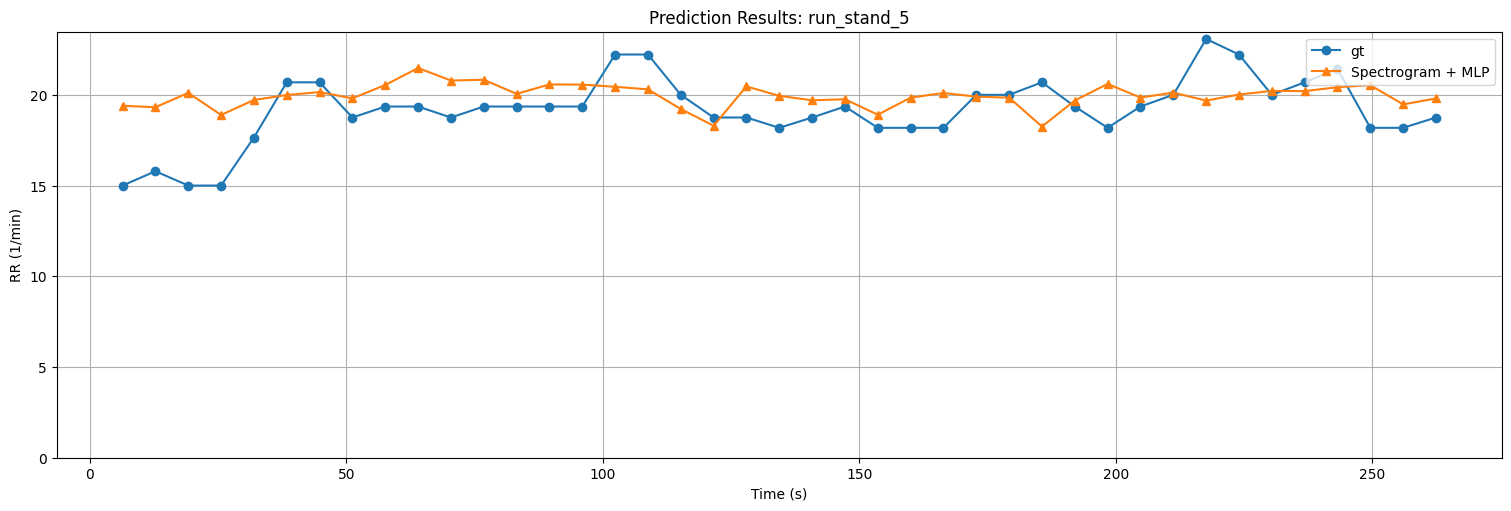

Evaluation Results - MSE Loss: 0.0010, L1 Loss: 1.5456 1/min


In [12]:
avg_mse_loss, avg_l1_loss, preds = evaluate_model_file(model, file_loader, gt=np.reshape(gts_file, (-1)), times=times_file, action_name=action_name)

In [13]:
# Load models
models_name = ['0327_MLP', '0327_CNN']
models = [MLP(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_1D(num_freq_bins, num_time_steps, num_channels=num_channels)]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(model, test_loader, model_name=models_name[i], device=device)

0327_MLP Evaluation Results - MSE Loss: 0.0029, L1 Loss: 2.3508 1/min
0327_CNN Evaluation Results - MSE Loss: 0.0029, L1 Loss: 2.3446 1/min


MLP Evaluation Results - MSE Loss: 0.0021, L1 Loss: 2.2335 1/min
CNN Evaluation Results - MSE Loss: 0.0010, L1 Loss: 1.5456 1/min


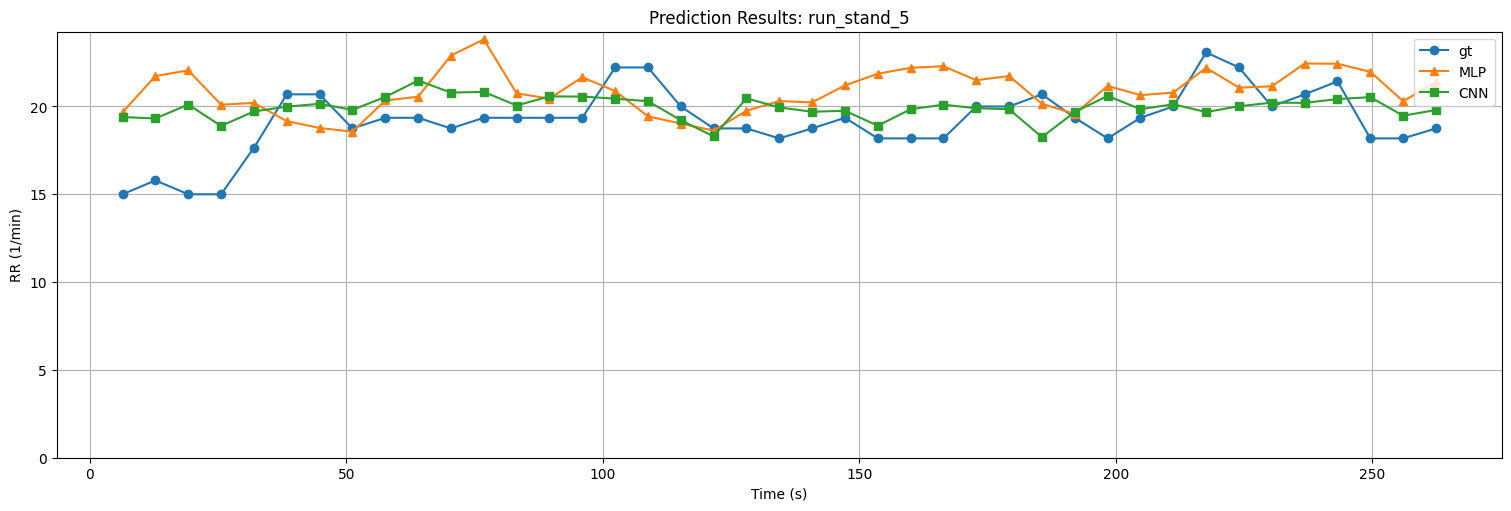

In [14]:
avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=["MLP", "CNN"], gt=np.reshape(gts_file, (-1)), times=times_file, action_name=action_name)